In [9]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [11]:
import sys
sys.path.insert(0, "/cellarold/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")

import lifelines
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import statsmodels.stats.multitest as multi
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from lifelines.statistics import logrank_test

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [13]:
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [14]:
print(lifelines.__version__)

0.27.3


In [15]:
import json
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [16]:
def fdr(df,pseudo,p):
    
    '''
    calculate Benjamini-Hochberg FDR
    pseudo: True or False
    '''
    
    #add pseudocounta
    if pseudo == True:
        df[p]=df[p]+0.000000000001
    
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

In [21]:
def compile_ldtrait(direct, cancer):
    
    '''
    Input: Directory with output from ldtrait.sh
    Output: Dataframe with LDtrait results
    '''
    
    ldtrait_df=pd.DataFrame() #compiled ldtrait dataframe
    
    for file in os.listdir(direct):
        file1 = open(direct+file,"r")
        lines=file1.readlines()
        
        for line in lines:
            if "}" in line:
                pass
            elif "error" in line:
                pass
            elif "{" in line:
                pass
            elif "NoneType" in line:
                pass
            else:
                ldtrait_df=ldtrait_df.append(pd.Series(line.strip().split("\t")).T,ignore_index=True)
    ldtrait_df=ldtrait_df[ldtrait_df[0]!="Query"]
    ldtrait_df.columns=["Query","GWAS Trait", "RS Number","Position (GRCh37)","Alleles","R2","D'","Risk Allele","Effect Size (95% CI)","Beta or OR","P-value"]
    
    if cancer:
        
        # filter for cancer gwas
        cancer=["melanoma","carcinoma","cancer"]

        cancer_gwas=pd.DataFrame()

        for x in cancer:
            gwas_filt=ldtrait_df[ldtrait_df["GWAS Trait"].str.contains(x)]
            cancer_gwas=cancer_gwas.append(gwas_filt)
            
        return(cancer_gwas)
    
    else:
        
        return(ldtrait_df)

## Cancer Risk

In [23]:
all_snp_table=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/mega_snp_table.txt",sep="\t")
snps=all_snp_table

In [22]:
ldtrait=compile_ldtrait("/cellar/users/mpagadal/projects/germline-immune/data/ldtrait/time-snp/","cancer")

In [24]:
snps["cancer_gwas"]=np.where(snps["proxy_snp"].isin(ldtrait["Query"].tolist()),"gwas","no")

In [25]:
print("{} GWAS Catalog associations from {} IP components".format(len(snps[snps["cancer_gwas"]=="gwas"]),len(snps[snps["cancer_gwas"]=="gwas"]["file"].unique())))

64 GWAS Catalog associations from 20 IP components


##### Get Vanderbilt associations

In [26]:
vanderbilt_phewas=pd.read_csv("/cellar/users/mpagadal/data/vanderbilt-phewas/combined_query_snp_list.txt",delimiter="\t")
vanderbilt_phewas=vanderbilt_phewas[vanderbilt_phewas["RS_Number"].isin(snps["proxy_snp"].tolist())]
vanderbilt_phewas_ld=vanderbilt_phewas[vanderbilt_phewas["R2"]>=0.5] #r2 filter of 0.5

In [27]:
snps["vanderbilt"]=np.where(snps["proxy_snp"].isin(vanderbilt_phewas_ld["RS_Number"].tolist()),"vanderbilt","no")

In [28]:
print("{} Vanderbilt PheWAS associations from {} IP components".format(len(snps[snps["vanderbilt"]=="vanderbilt"]),len(snps[snps["vanderbilt"]=="vanderbilt"]["file"].unique())))


92 Vanderbilt PheWAS associations from 36 IP components


##### look at overlap between all methods

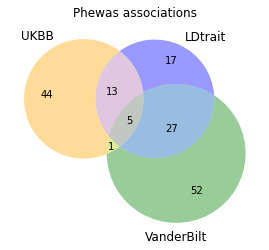

In [32]:
plt.title("Phewas associations")
venn3([set(snps.loc[snps["risk_either"]=="yes","rsid"].tolist()),set(ldtrait["Query"].tolist()),set(vanderbilt_phewas_ld["RS_Number"].tolist())],
      set_labels=("UKBB","LDtrait","VanderBilt"), set_colors=["orange","blue","green"])
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_risk.snp.overlap.pdf")

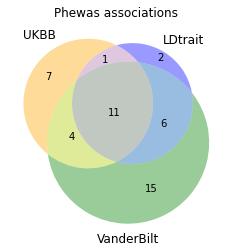

In [35]:
plt.title("Phewas associations")
venn3([set(snps.loc[snps["risk_either"]=="yes","file"].tolist()),set(snps[snps["rsid"].isin(ldtrait["Query"].tolist())]["file"].unique().tolist()),set(set(snps[snps["rsid"].isin(vanderbilt_phewas_ld["RS_Number"].tolist())]["file"].unique().tolist()))],
      set_labels=("UKBB","LDtrait","VanderBilt"), set_colors=["orange","blue","green"])
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_IP_risk.snp.overlap.pdf")

In [36]:
vanderbilt_pheno=snps[snps["vanderbilt"]=="vanderbilt"]["file"].unique().tolist()
ldtrait_pheno=snps[snps["cancer_gwas"]=="gwas"]["file"].unique().tolist()
ukbb_pheno=snps[snps["risk_either"]=="yes"]["file"].unique().tolist()

## Cancer Survival x Risk x ICB

In [38]:
len(set(all_snp_table.loc[all_snp_table["OS_PFS"]=="yes","snps"].tolist()))

442

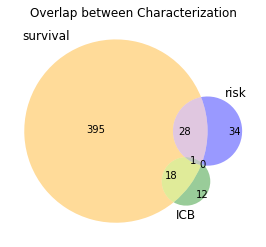

In [39]:
plt.title("Overlap between Characterization")
venn3([set(all_snp_table.loc[all_snp_table["OS_PFS"]=="yes","snps"].tolist()),set(all_snp_table.loc[all_snp_table["risk_either"]=="yes","snps"].tolist()),set(all_snp_table.loc[all_snp_table["icb_filt"]=="yes","snps"].tolist())],
      set_labels=("survival","risk","ICB"), set_colors=["orange","blue","green"])

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_all.snp.overlap_venn.pdf")


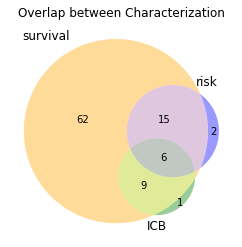

In [40]:
plt.title("Overlap between Characterization")
venn3([set(all_snp_table.loc[all_snp_table["OS_PFS"]=="yes","file"].tolist()),set(all_snp_table.loc[all_snp_table["risk_either"]=="yes","file"].tolist()),set(all_snp_table.loc[all_snp_table["icb_filt"]=="yes","file"].tolist())],
      set_labels=("survival","risk","ICB"), set_colors=["orange","blue","green"])

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_IP_.overlap_venn.pdf")


## VEP bar plots